# Operations de Base sur l'Audio

**Module :** 01-Audio-Foundation  
**Niveau :** Debutant  
**Technologies :** librosa, soundfile, pydub, matplotlib  
**Duree estimee :** 35 minutes  
**VRAM :** 0 (CPU uniquement)  

## Objectifs d'Apprentissage

- [ ] Charger et analyser des fichiers audio avec librosa
- [ ] Visualiser des formes d'onde (waveform)
- [ ] Generer et interpreter des spectrogrammes (mel, STFT)
- [ ] Comprendre les MFCC (Mel-Frequency Cepstral Coefficients)
- [ ] Manipuler l'audio avec pydub (conversion, trimming, concatenation)
- [ ] Extraire des caracteristiques audio (tempo, pitch, energie)
- [ ] Utiliser les fonctions du module audio_helpers.py

## Prerequis

- Environment Setup (module 00) complete
- Notions de base en Python et numpy
- Cle API OpenAI recommandee (pour generer un echantillon) mais pas obligatoire

**Navigation :** [Index](../README.md) | [<< Precedent](01-2-OpenAI-Whisper-STT.ipynb) | [Suivant >>](01-4-Whisper-Local.ipynb)

In [1]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration notebook
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"

# Parametres audio
sample_duration = 5                # Duree de l'echantillon de test (secondes)
sample_rate = 22050                # Taux d'echantillonnage par defaut

# Configuration
generate_sample_via_tts = True     # Generer un echantillon avec OpenAI TTS
show_visualizations = True         # Afficher les visualisations
test_pydub_ops = True              # Tester les operations pydub
save_results = True                # Sauvegarder les resultats

In [2]:
# Setup environnement et imports
import os
import sys
import json
import time
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
from io import BytesIO
import logging

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Imports audio
import librosa
import librosa.display
import soundfile as sf

# Lecture audio dans Jupyter
from IPython.display import Audio, display

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Import helpers GenAI
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.audio_helpers import (
            plot_waveform, plot_spectrogram, plot_mfcc,
            load_audio, save_audio, play_audio, get_audio_info
        )
        HELPERS_AVAILABLE = True
        print("Helpers audio importes")
    except ImportError:
        HELPERS_AVAILABLE = False
        print("Helpers audio non disponibles - mode autonome")
else:
    HELPERS_AVAILABLE = False

# Repertoires
OUTPUT_DIR = GENAI_ROOT / 'outputs' / 'audio' / 'operations'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
SAMPLES_DIR = GENAI_ROOT / 'outputs' / 'audio' / 'samples'
SAMPLES_DIR.mkdir(parents=True, exist_ok=True)

# Configuration logging
logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('audio_ops')

print(f"Operations de Base sur l'Audio")
print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"librosa : {librosa.__version__}")
print(f"Sortie : {OUTPUT_DIR}")

Helpers audio importes
Operations de Base sur l'Audio
Date : 2026-02-18 01:01:13
Mode : interactive
librosa : 0.11.0
Sortie : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\audio\operations


In [3]:
# Chargement .env et preparation de l'echantillon audio
from dotenv import load_dotenv

current_path = Path.cwd()
found_env = False
for _ in range(4):
    env_path = current_path / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis : {env_path}")
        found_env = True
        break
    current_path = current_path.parent

# Preparation de l'echantillon audio
sample_path = SAMPLES_DIR / "sample_fr.mp3"
audio_data = None
sr = sample_rate

if sample_path.exists():
    print(f"Echantillon existant trouve : {sample_path.name}")
    audio_data, sr = librosa.load(str(sample_path), sr=sample_rate)
    print(f"  Duree : {len(audio_data)/sr:.1f}s, Sample rate : {sr} Hz")

elif generate_sample_via_tts:
    openai_key = os.getenv('OPENAI_API_KEY')
    if openai_key:
        from openai import OpenAI
        client = OpenAI(api_key=openai_key)

        tts_text = (
            "Le traitement numerique du signal audio permet d'analyser "
            "les sons en termes de frequences, d'amplitude et de temps. "
            "Les spectrogrammes revelent la structure frequentielle "
            "des signaux audio."
        )

        print("Generation de l'echantillon via TTS...")
        response = client.audio.speech.create(
            model="tts-1", voice="nova",
            input=tts_text, response_format="mp3"
        )
        with open(sample_path, 'wb') as f:
            f.write(response.content)

        audio_data, sr = librosa.load(str(sample_path), sr=sample_rate)
        print(f"Echantillon genere : {sample_path.name}")
        print(f"  Duree : {len(audio_data)/sr:.1f}s, Sample rate : {sr} Hz")
        display(Audio(data=audio_data, rate=sr))
    else:
        print("OPENAI_API_KEY non disponible, generation d'un signal synthetique")

# Fallback : signal synthetique
if audio_data is None:
    print("Generation d'un signal synthetique de test...")
    t = np.linspace(0, sample_duration, sample_duration * sample_rate, endpoint=False)
    # Signal compose : fondamentale 440 Hz + harmoniques
    audio_data = (
        0.5 * np.sin(2 * np.pi * 440 * t) +
        0.3 * np.sin(2 * np.pi * 880 * t) +
        0.1 * np.sin(2 * np.pi * 1320 * t)
    ).astype(np.float32)
    sr = sample_rate
    print(f"Signal synthetique : {sample_duration}s, {sr} Hz, 440 Hz + harmoniques")

print(f"\nEchantillon pret : {len(audio_data)} echantillons, {len(audio_data)/sr:.1f}s")

Fichier .env charge depuis : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\.env
Echantillon existant trouve : sample_fr.mp3


  Duree : 11.8s, Sample rate : 22050 Hz

Echantillon pret : 259838 echantillons, 11.8s


## Section 1 : Forme d'onde (Waveform)

La forme d'onde est la representation la plus directe d'un signal audio : l'amplitude en fonction du temps.

| Concept | Description |
|---------|-------------|
| Amplitude | Intensite du signal a un instant donne (-1.0 a 1.0 en normalise) |
| Sample rate | Nombre d'echantillons par seconde (ex: 22050 Hz, 44100 Hz) |
| Duree | Nombre d'echantillons / sample rate |

FORME D'ONDE (WAVEFORM)


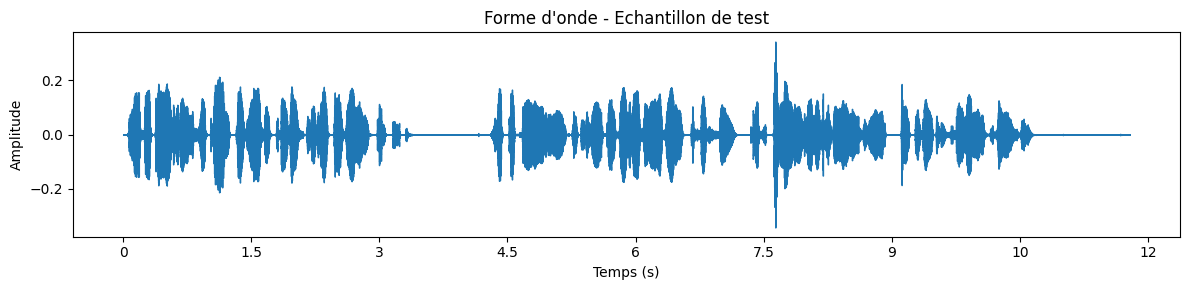


Statistiques du signal :
  Duree : 11.78s
  Sample rate : 22050 Hz
  Echantillons : 259,838
  Amplitude max : 0.3432
  Amplitude moyenne : 0.0194
  RMS : 0.0334
  Dynamique (dB) : 20.2 dB


In [4]:
# Visualisation de la forme d'onde
print("FORME D'ONDE (WAVEFORM)")
print("=" * 45)

if show_visualizations:
    # Utiliser les helpers si disponibles
    if HELPERS_AVAILABLE:
        plot_waveform(audio_data, sr, title="Forme d'onde - Echantillon de test")
    else:
        fig, ax = plt.subplots(figsize=(12, 3))
        librosa.display.waveshow(audio_data, sr=sr, ax=ax)
        ax.set_title("Forme d'onde - Echantillon de test")
        ax.set_xlabel("Temps (s)")
        ax.set_ylabel("Amplitude")
        plt.tight_layout()
        plt.show()

    # Statistiques du signal
    print(f"\nStatistiques du signal :")
    print(f"  Duree : {len(audio_data)/sr:.2f}s")
    print(f"  Sample rate : {sr} Hz")
    print(f"  Echantillons : {len(audio_data):,}")
    print(f"  Amplitude max : {np.max(np.abs(audio_data)):.4f}")
    print(f"  Amplitude moyenne : {np.mean(np.abs(audio_data)):.4f}")
    print(f"  RMS : {np.sqrt(np.mean(audio_data**2)):.4f}")
    print(f"  Dynamique (dB) : {20 * np.log10(np.max(np.abs(audio_data)) / (np.sqrt(np.mean(audio_data**2)) + 1e-10)):.1f} dB")
else:
    print("Visualisations desactivees")

## Section 2 : Spectrogrammes

Un spectrogramme montre comment les frequences evoluent dans le temps. C'est l'outil fondamental de l'analyse audio.

### Types de spectrogrammes

| Type | Description | Usage |
|------|-------------|-------|
| STFT | Transformee de Fourier a court terme | Analyse frequentielle brute |
| Mel | Echelle mel (perception humaine) | STT, classification audio |
| Chromagramme | Notes musicales (C, D, E...) | Analyse musicale |

L'echelle mel compresse les hautes frequences, imitant la perception humaine : nous distinguons mieux les differences dans les basses frequences.

SPECTROGRAMMES


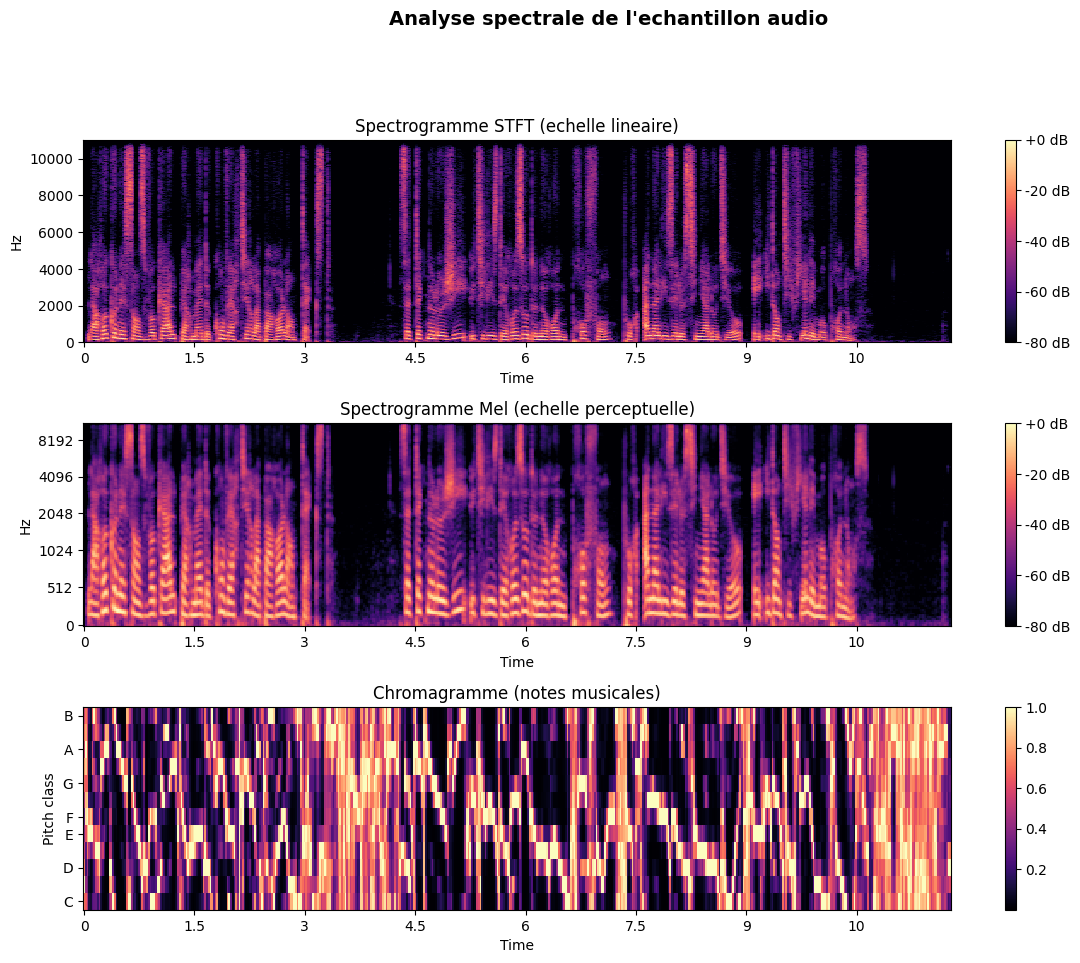


Dimensions spectrogramme STFT : (1025, 508) (frequences x frames)
Dimensions spectrogramme Mel : (128, 508) (mels x frames)
Dimensions chromagramme : (12, 508) (notes x frames)


In [5]:
# Spectrogrammes
print("SPECTROGRAMMES")
print("=" * 45)

if show_visualizations:
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(3, 1, figure=fig, hspace=0.4)

    # 1. Spectrogramme STFT
    ax1 = fig.add_subplot(gs[0])
    D = librosa.stft(audio_data)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img1 = librosa.display.specshow(S_db, x_axis='time', y_axis='hz', sr=sr, ax=ax1)
    fig.colorbar(img1, ax=ax1, format='%+2.0f dB')
    ax1.set_title("Spectrogramme STFT (echelle lineaire)")

    # 2. Spectrogramme Mel
    ax2 = fig.add_subplot(gs[1])
    S_mel = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128)
    S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
    img2 = librosa.display.specshow(S_mel_db, x_axis='time', y_axis='mel', sr=sr, ax=ax2)
    fig.colorbar(img2, ax=ax2, format='%+2.0f dB')
    ax2.set_title("Spectrogramme Mel (echelle perceptuelle)")

    # 3. Chromagramme
    ax3 = fig.add_subplot(gs[2])
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    img3 = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr, ax=ax3)
    fig.colorbar(img3, ax=ax3)
    ax3.set_title("Chromagramme (notes musicales)")

    plt.suptitle("Analyse spectrale de l'echantillon audio", fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()

    print(f"\nDimensions spectrogramme STFT : {S_db.shape} (frequences x frames)")
    print(f"Dimensions spectrogramme Mel : {S_mel_db.shape} (mels x frames)")
    print(f"Dimensions chromagramme : {chroma.shape} (notes x frames)")
else:
    print("Visualisations desactivees")

### Interpretation : Spectrogrammes

| Type | Axes | Ce qu'on observe |
|------|------|------------------|
| STFT | Frequence (Hz) vs Temps | Structure frequentielle detaillee |
| Mel | Mel bins vs Temps | Representation perceptuelle, concentree sur les basses |
| Chroma | Note (C-B) vs Temps | Contenu harmonique, tonalite |

**Points cles** :
1. Le spectrogramme Mel est le format d'entree standard pour les modeles de reconnaissance vocale (Whisper inclus)
2. La voix humaine occupe principalement la bande 80 Hz - 8000 Hz
3. Les zones claires (haute energie) correspondent aux sons vocaliques

## Section 3 : MFCC (Mel-Frequency Cepstral Coefficients)

Les MFCC sont la representation la plus utilisee en reconnaissance vocale. Ils capturent l'enveloppe spectrale du signal, qui encode l'information phonetique.

### Pipeline de calcul

1. **Pre-emphasis** : Amplifier les hautes frequences
2. **Fenetrage** : Decouper en trames de ~25ms
3. **FFT** : Calcul du spectre de puissance
4. **Banc de filtres Mel** : Application de filtres triangulaires
5. **Log** : Passage en echelle logarithmique
6. **DCT** : Transformee en cosinus discrete

On garde typiquement 13 a 20 coefficients.

MFCC (Mel-Frequency Cepstral Coefficients)


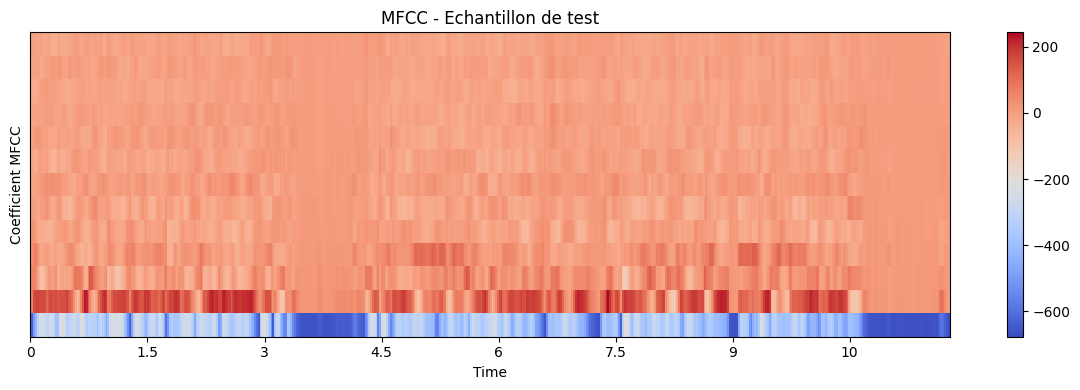


Statistiques MFCC :
  Nombre de coefficients : 13
  Frames temporelles : 508
  Dimensions : (13, 508)

  Moyenne par coefficient :
    MFCC[0] : moy=-421.82, std=137.11
    MFCC[1] : moy=94.62, std=82.10
    MFCC[2] : moy=20.82, std=40.16
    MFCC[3] : moy=24.71, std=35.74
    MFCC[4] : moy=-4.29, std=22.61
    ... (8 coefficients supplementaires)


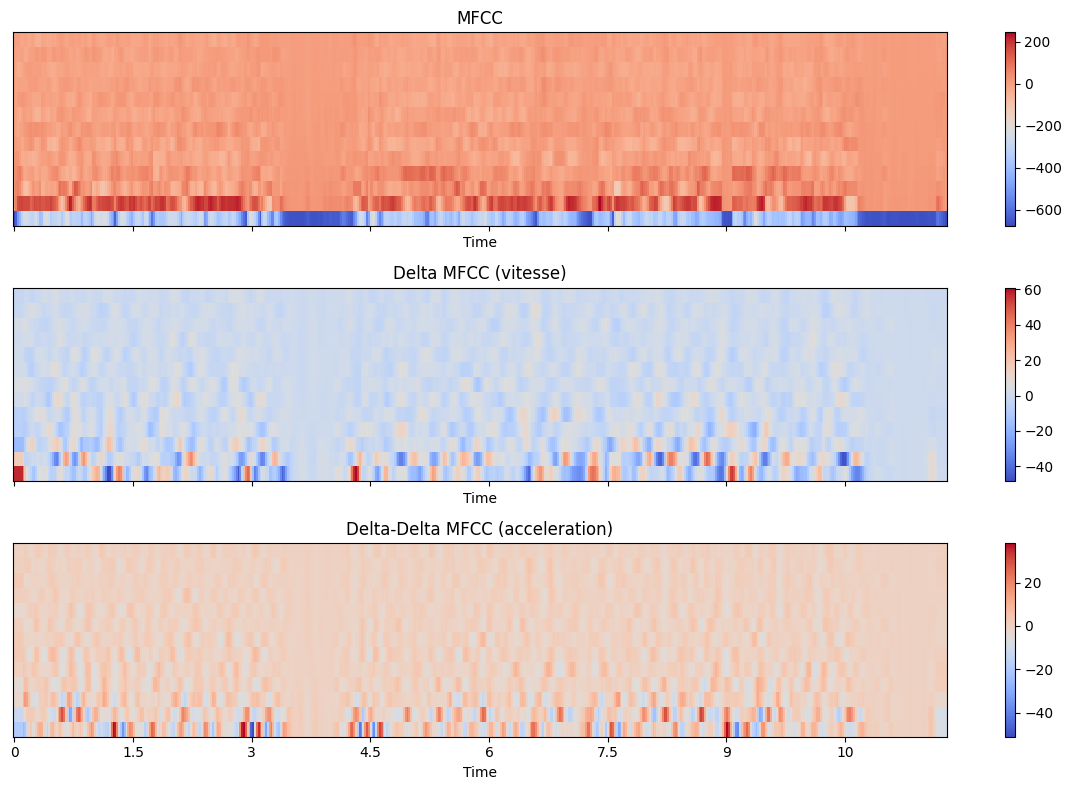


Les Delta-MFCC capturent la dynamique temporelle du signal


In [6]:
# MFCC
print("MFCC (Mel-Frequency Cepstral Coefficients)")
print("=" * 45)

if show_visualizations:
    n_mfcc = 13

    # Calcul des MFCC
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=n_mfcc)

    # Utiliser les helpers si disponibles
    if HELPERS_AVAILABLE:
        plot_mfcc(audio_data, sr, n_mfcc=n_mfcc, title="MFCC - Echantillon de test")
    else:
        fig, ax = plt.subplots(figsize=(12, 4))
        img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
        fig.colorbar(img, ax=ax)
        ax.set_title("MFCC - Echantillon de test")
        ax.set_ylabel("Coefficient MFCC")
        plt.tight_layout()
        plt.show()

    # Statistiques MFCC
    print(f"\nStatistiques MFCC :")
    print(f"  Nombre de coefficients : {n_mfcc}")
    print(f"  Frames temporelles : {mfccs.shape[1]}")
    print(f"  Dimensions : {mfccs.shape}")
    print(f"\n  Moyenne par coefficient :")
    for i in range(min(n_mfcc, 5)):
        print(f"    MFCC[{i}] : moy={np.mean(mfccs[i]):.2f}, std={np.std(mfccs[i]):.2f}")
    if n_mfcc > 5:
        print(f"    ... ({n_mfcc - 5} coefficients supplementaires)")

    # Delta MFCC (vitesse de changement)
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    for ax, data, title in zip(axes, [mfccs, mfcc_delta, mfcc_delta2],
                                ["MFCC", "Delta MFCC (vitesse)", "Delta-Delta MFCC (acceleration)"]):
        img = librosa.display.specshow(data, x_axis='time', ax=ax)
        fig.colorbar(img, ax=ax)
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

    print(f"\nLes Delta-MFCC capturent la dynamique temporelle du signal")
else:
    print("Visualisations desactivees")

## Section 4 : Manipulations avec pydub

pydub est une bibliotheque de haut niveau pour manipuler l'audio :

| Operation | Description | Methode |
|-----------|-------------|--------|
| Conversion de format | MP3 -> WAV, FLAC, etc. | `audio.export(format=...)` |
| Trimming | Extraire un segment | `audio[start_ms:end_ms]` |
| Concatenation | Assembler des segments | `audio1 + audio2` |
| Volume | Ajuster le volume | `audio + dB` ou `audio - dB` |
| Fade | Fondu en entree/sortie | `audio.fade_in(ms).fade_out(ms)` |

In [7]:
# Manipulations avec pydub
print("MANIPULATIONS PYDUB")
print("=" * 45)

if test_pydub_ops:
    from pydub import AudioSegment

    # Charger l'echantillon - essayer WAV d'abord (pas besoin de ffmpeg)
    sample_wav = SAMPLES_DIR / "sample_fr.wav"
    sample_mp3 = SAMPLES_DIR / "sample_fr.mp3"
    
    # Generer un WAV si inexistant (pydub peut lire WAV sans ffmpeg)
    if sample_wav.exists():
        sample_file = sample_wav
        print(f"Fichier WAV existant trouve : {sample_wav.name}")
    elif sample_mp3.exists():
        # Convertir MP3 vers WAV avec soundfile
        print(f"Conversion MP3 -> WAV pour compatibilite pydub...")
        audio_temp, sr_temp = librosa.load(str(sample_mp3), sr=None)
        sf.write(str(sample_wav), audio_temp, sr_temp)
        sample_file = sample_wav
        print(f"  Fichier WAV cree : {sample_wav.name}")
    else:
        # Generer WAV depuis les donnees numpy
        print(f"Generation WAV depuis les donnees numpy...")
        sf.write(str(sample_wav), audio_data, sr)
        sample_file = sample_wav
    
    # Charger avec pydub (WAV ne necessite pas ffmpeg)
    audio_seg = None
    ffmpeg_available = False
    try:
        # Tester si ffmpeg est disponible
        import subprocess
        result = subprocess.run(['ffmpeg', '-version'], capture_output=True, timeout=2)
        ffmpeg_available = True
    except (FileNotFoundError, subprocess.SubprocessError, Exception):
        ffmpeg_available = False
    
    if sample_file.exists() and ffmpeg_available:
        try:
            audio_seg = AudioSegment.from_wav(str(sample_file))
            print(f"Audio charge via pydub + ffmpeg")
        except Exception as e:
            print(f"Erreur chargement avec pydub: {e}")
            ffmpeg_available = False
    
    if audio_seg is None:
        # Fallback : creer un segment depuis les donnees numpy (pas besoin de ffmpeg)
        print(f"Creation AudioSegment depuis les donnees numpy (pas besoin de ffmpeg)...")
        audio_int16 = (audio_data * 32767).astype(np.int16)
        audio_seg = AudioSegment(
            data=audio_int16.tobytes(),
            sample_width=2, frame_rate=sr, channels=1
        )

    print(f"Audio charge :")
    print(f"  Duree : {len(audio_seg) / 1000:.1f}s")
    print(f"  Channels : {audio_seg.channels}")
    print(f"  Sample rate : {audio_seg.frame_rate} Hz")
    print(f"  Sample width : {audio_seg.sample_width} bytes")
    print(f"  dBFS : {audio_seg.dBFS:.1f} dB")
    print(f"  ffmpeg disponible : {ffmpeg_available}")

    # --- Trimming ---
    print(f"\n--- Trimming ---")
    first_half = audio_seg[:len(audio_seg)//2]
    last_2s = audio_seg[-2000:]
    print(f"  Premiere moitie : {len(first_half)/1000:.1f}s")
    print(f"  Derniers 2s : {len(last_2s)/1000:.1f}s")

    # --- Volume ---
    print(f"\n--- Ajustement volume ---")
    louder = audio_seg + 6    # +6 dB
    quieter = audio_seg - 6   # -6 dB
    print(f"  Original : {audio_seg.dBFS:.1f} dBFS")
    print(f"  +6 dB    : {louder.dBFS:.1f} dBFS")
    print(f"  -6 dB    : {quieter.dBFS:.1f} dBFS")

    # --- Fade in/out ---
    print(f"\n--- Fade in/out ---")
    faded = audio_seg.fade_in(500).fade_out(500)
    print(f"  Fade in : 500ms, Fade out : 500ms")

    # --- Concatenation ---
    print(f"\n--- Concatenation ---")
    silence = AudioSegment.silent(duration=500)  # 500ms de silence
    concatenated = first_half + silence + last_2s
    print(f"  Resultat : {len(concatenated)/1000:.1f}s (premiere moitie + silence + fin)")

    # --- Sauvegarde avec soundfile (pas besoin de ffmpeg) ---
    print(f"\n--- Sauvegarde des resultats ---")
    
    # Convertir AudioSegment vers numpy pour sauvegarde avec soundfile
    def audiosegment_to_numpy(segment):
        """Convertir pydub AudioSegment vers numpy array."""
        samples = np.array(segment.get_array_of_samples())
        if segment.channels == 2:
            samples = samples.reshape((-1, 2))
        # Normaliser vers [-1, 1]
        return samples.astype(np.float32) / 32768.0
    
    # Sauvegarder le resultat concatene
    concat_path = OUTPUT_DIR / "concatenated.wav"
    concat_samples = audiosegment_to_numpy(concatenated)
    sf.write(str(concat_path), concat_samples, concatenated.frame_rate)
    size_kb = concat_path.stat().st_size / 1024
    print(f"  WAV : {concat_path.name} ({size_kb:.1f} KB)")
    
    # Sauvegarder FLAC aussi (soundfile le supporte)
    flac_path = OUTPUT_DIR / "converted.flac"
    sf.write(str(flac_path), concat_samples, concatenated.frame_rate, format='FLAC')
    size_kb = flac_path.stat().st_size / 1024
    print(f"  FLAC : {flac_path.name} ({size_kb:.1f} KB)")

    # Ecoute du resultat concatene
    print(f"\nEcoute du resultat concatene :")
    concat_data, concat_sr = librosa.load(str(concat_path), sr=None)
    display(Audio(data=concat_data, rate=concat_sr))
    
    print(f"\nNote: pydub fonctionne pour les manipulations en memoire.")
    print(f"Pour l'export vers MP3/autres formats, installez ffmpeg:")
    print(f"  Windows: winget install Gyan.FFmpeg")
    print(f"  Linux: sudo apt install ffmpeg")
else:
    print("Operations pydub desactivees")

MANIPULATIONS PYDUB
Fichier WAV existant trouve : sample_fr.wav
Creation AudioSegment depuis les donnees numpy (pas besoin de ffmpeg)...
Audio charge :
  Duree : 11.8s
  Channels : 1
  Sample rate : 22050 Hz
  Sample width : 2 bytes
  dBFS : -29.5 dB
  ffmpeg disponible : False

--- Trimming ---
  Premiere moitie : 5.9s
  Derniers 2s : 2.0s

--- Ajustement volume ---
  Original : -29.5 dBFS
  +6 dB    : -23.5 dBFS
  -6 dB    : -35.5 dBFS

--- Fade in/out ---
  Fade in : 500ms, Fade out : 500ms

--- Concatenation ---
  Resultat : 8.4s (premiere moitie + silence + fin)

--- Sauvegarde des resultats ---
  WAV : concatenated.wav (361.5 KB)
  FLAC : converted.flac (141.4 KB)

Ecoute du resultat concatene :


C:\Users\jsboi\AppData\Roaming\Python\Python313\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)



Note: pydub fonctionne pour les manipulations en memoire.
Pour l'export vers MP3/autres formats, installez ffmpeg:
  Windows: winget install Gyan.FFmpeg
  Linux: sudo apt install ffmpeg


## Section 5 : Extraction de caracteristiques audio

librosa permet d'extraire des caracteristiques de haut niveau :

| Caracteristique | Description | Unite |
|-----------------|-------------|-------|
| Tempo | Vitesse rythmique | BPM |
| Zero-Crossing Rate | Frequence de passage par zero | Hz |
| Spectral Centroid | Centre de gravite spectral | Hz |
| Spectral Bandwidth | Largeur spectrale | Hz |
| RMS Energy | Energie quadratique moyenne | - |

EXTRACTION DE CARACTERISTIQUES


  Tempo estime : 143.6 BPM
  Zero-Crossing Rate (moy) : 0.1149
  Spectral Centroid (moy) : 2280.8 Hz
  Spectral Bandwidth (moy) : 2089.3 Hz
  Spectral Rolloff (moy) : 4265.7 Hz
  RMS Energy (moy) : 0.0268


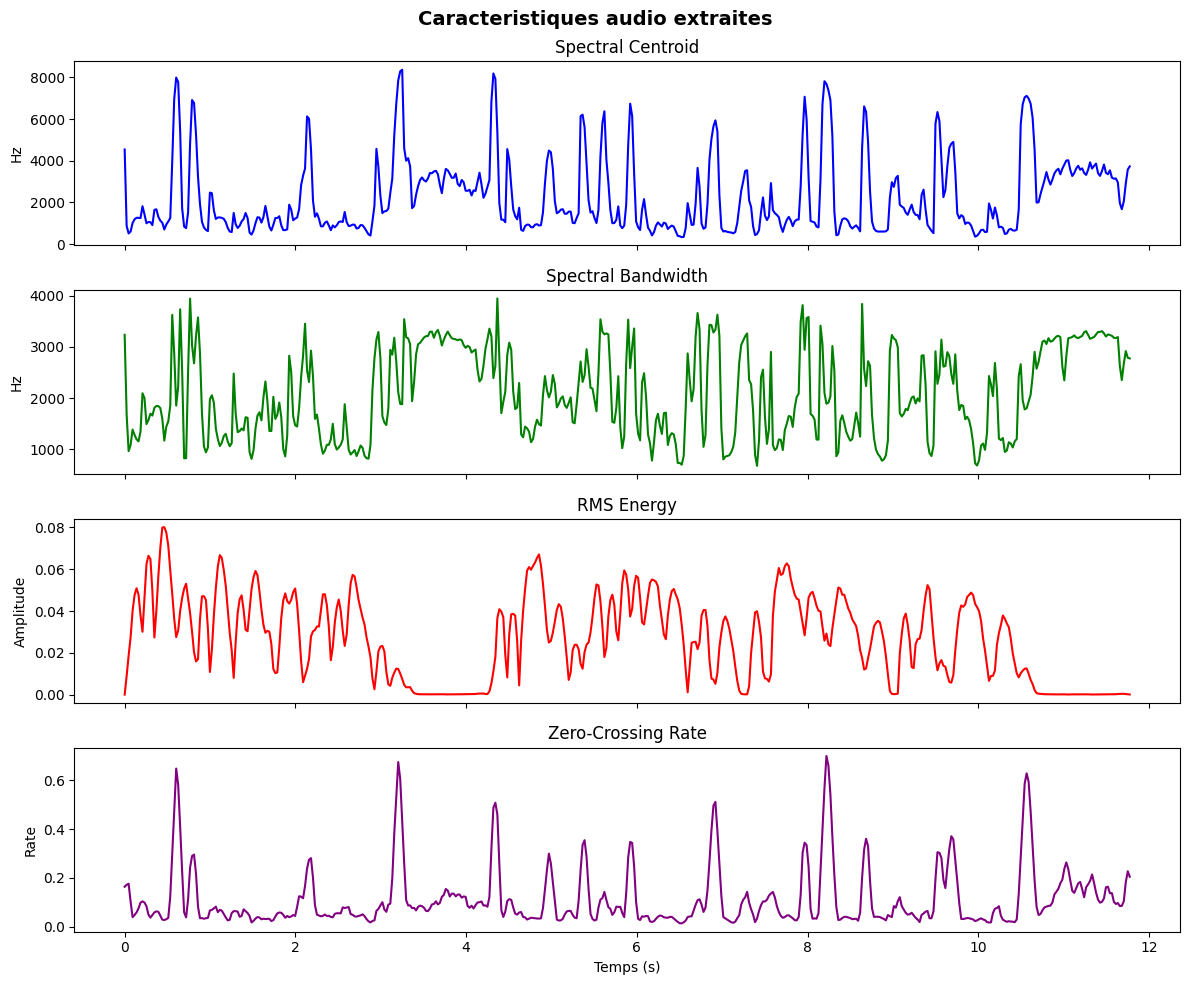

In [8]:
# Extraction de caracteristiques
print("EXTRACTION DE CARACTERISTIQUES")
print("=" * 45)

# Tempo
tempo, beat_frames = librosa.beat.beat_track(y=audio_data, sr=sr)
tempo_value = float(tempo) if np.isscalar(tempo) else float(tempo[0])
print(f"  Tempo estime : {tempo_value:.1f} BPM")

# Zero-Crossing Rate
zcr = librosa.feature.zero_crossing_rate(audio_data)
print(f"  Zero-Crossing Rate (moy) : {np.mean(zcr):.4f}")

# Spectral Centroid
spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
print(f"  Spectral Centroid (moy) : {np.mean(spectral_centroid):.1f} Hz")

# Spectral Bandwidth
spectral_bw = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
print(f"  Spectral Bandwidth (moy) : {np.mean(spectral_bw):.1f} Hz")

# Spectral Rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)
print(f"  Spectral Rolloff (moy) : {np.mean(spectral_rolloff):.1f} Hz")

# RMS Energy
rms = librosa.feature.rms(y=audio_data)
print(f"  RMS Energy (moy) : {np.mean(rms):.4f}")

# Visualisation des caracteristiques
if show_visualizations:
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    frames = range(len(spectral_centroid[0]))
    t_frames = librosa.frames_to_time(list(frames), sr=sr)

    axes[0].plot(t_frames, spectral_centroid[0], color='blue')
    axes[0].set_title("Spectral Centroid")
    axes[0].set_ylabel("Hz")

    axes[1].plot(t_frames, spectral_bw[0], color='green')
    axes[1].set_title("Spectral Bandwidth")
    axes[1].set_ylabel("Hz")

    t_rms = librosa.frames_to_time(list(range(len(rms[0]))), sr=sr)
    axes[2].plot(t_rms, rms[0], color='red')
    axes[2].set_title("RMS Energy")
    axes[2].set_ylabel("Amplitude")

    t_zcr = librosa.frames_to_time(list(range(len(zcr[0]))), sr=sr)
    axes[3].plot(t_zcr, zcr[0], color='purple')
    axes[3].set_title("Zero-Crossing Rate")
    axes[3].set_ylabel("Rate")
    axes[3].set_xlabel("Temps (s)")

    plt.suptitle("Caracteristiques audio extraites", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

### Interpretation : Caracteristiques audio

| Caracteristique | Valeur basse | Valeur haute |
|-----------------|-------------|---------------|
| Spectral Centroid | Sons graves, sombres | Sons aigus, brillants |
| Spectral Bandwidth | Signal tonal pur | Signal bruyanf, riche |
| ZCR | Voix grave, voyelles | Consonnes fricatives, bruit |
| RMS | Silence, pauses | Parole forte, musique |

> **Note technique** : Ces caracteristiques sont utilisees dans les systemes de classification audio (genre musical, detection de parole vs musique, reconnaissance d'emotions).

In [9]:
# Mode interactif
if notebook_mode == "interactive" and not skip_widgets:
    print("MODE INTERACTIF")
    print("=" * 50)
    print("\nEntrez le chemin d'un fichier audio a analyser :")
    print("(Laissez vide pour passer a la suite)")

    try:
        user_path = input("\nChemin du fichier audio : ")

        if user_path.strip():
            user_file = Path(user_path.strip())
            if user_file.exists():
                user_audio, user_sr = librosa.load(str(user_file), sr=None)
                print(f"\nFichier charge : {user_file.name}")
                print(f"  Duree : {len(user_audio)/user_sr:.1f}s")
                print(f"  Sample rate : {user_sr} Hz")

                # Visualisations
                if HELPERS_AVAILABLE:
                    plot_waveform(user_audio, user_sr, title=f"Forme d'onde - {user_file.name}")
                    plot_spectrogram(user_audio, user_sr, title=f"Spectrogramme - {user_file.name}")
                    plot_mfcc(user_audio, user_sr, title=f"MFCC - {user_file.name}")
                display(Audio(data=user_audio, rate=user_sr))
            else:
                print(f"Fichier non trouve : {user_file}")
        else:
            print("Mode interactif ignore")

    except (KeyboardInterrupt, EOFError):
        print("Mode interactif interrompu")
    except Exception as e:
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type or "input" in str(e).lower():
            print("Mode interactif non disponible (execution automatisee)")
        else:
            print(f"Erreur : {error_type} - {str(e)[:100]}")
else:
    print("Mode batch - Interface interactive desactivee")

MODE INTERACTIF

Entrez le chemin d'un fichier audio a analyser :
(Laissez vide pour passer a la suite)
Mode interactif non disponible (execution automatisee)


## Bonnes pratiques et recapitulatif

### Guide de selection des outils

| Tache | Outil recommande | Raison |
|-------|-----------------|--------|
| Analyse spectrale | librosa | API complete, visualisations integrees |
| Lecture/ecriture formats | soundfile | Support natif WAV, FLAC, OGG |
| Conversion, montage | pydub | API de haut niveau, simple |
| Visualisation | matplotlib + librosa.display | Integration parfaite |
| Lecture dans Jupyter | IPython.display.Audio | Lecteur integre |

### Representations cles pour le ML

| Representation | Usage ML | Dimensions typiques |
|----------------|----------|--------------------|
| Mel Spectrogram | Entree Whisper, classification | (128, T) |
| MFCC | Classification traditionnelle | (13-20, T) |
| Raw waveform | WaveNet, modeles end-to-end | (N,) |

In [10]:
# Statistiques de session et prochaines etapes
print("STATISTIQUES DE SESSION")
print("=" * 45)

print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Duree echantillon analyse : {len(audio_data)/sr:.1f}s")
print(f"Sample rate : {sr} Hz")
print(f"Helpers audio : {'disponibles' if HELPERS_AVAILABLE else 'non disponibles'}")

if save_results:
    saved = list(OUTPUT_DIR.glob('*'))
    print(f"Fichiers sauvegardes : {len(saved)} dans {OUTPUT_DIR}")

print(f"\nOperations couvertes :")
print(f"  1. Forme d'onde (waveform) et statistiques temporelles")
print(f"  2. Spectrogrammes (STFT, Mel, Chromagramme)")
print(f"  3. MFCC et Delta-MFCC")
print(f"  4. Manipulations pydub (trim, concat, volume, conversion)")
print(f"  5. Extraction de caracteristiques (tempo, centroid, etc.)")

print(f"\nPROCHAINES ETAPES")
print(f"1. Tester Whisper en local avec GPU (01-4-Whisper-Local)")
print(f"2. Essayer le TTS local avec Kokoro (01-5-Kokoro-TTS-Local)")
print(f"3. Explorer le voice cloning (02-2-XTTS-Voice-Cloning)")
print(f"4. Decouvrir la separation de sources (02-4-Demucs)")

print(f"\nNotebook Operations Audio termine - {datetime.now().strftime('%H:%M:%S')}")

STATISTIQUES DE SESSION
Date : 2026-02-18 01:01:18
Duree echantillon analyse : 11.8s
Sample rate : 22050 Hz
Helpers audio : disponibles
Fichiers sauvegardes : 3 dans D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\audio\operations

Operations couvertes :
  1. Forme d'onde (waveform) et statistiques temporelles
  2. Spectrogrammes (STFT, Mel, Chromagramme)
  3. MFCC et Delta-MFCC
  4. Manipulations pydub (trim, concat, volume, conversion)
  5. Extraction de caracteristiques (tempo, centroid, etc.)

PROCHAINES ETAPES
1. Tester Whisper en local avec GPU (01-4-Whisper-Local)
2. Essayer le TTS local avec Kokoro (01-5-Kokoro-TTS-Local)
3. Explorer le voice cloning (02-2-XTTS-Voice-Cloning)
4. Decouvrir la separation de sources (02-4-Demucs)

Notebook Operations Audio termine - 01:01:18


---

# CHALLENGE BONUS - Boucle Conversationnelle Audio

**Points : 15 pts**

## Objectif

Creer une boucle conversationnelle qui combine reconnaissance vocale et synthese vocale.

## Criteres de succes

- [ ] Le code capture l'audio microphone (5 secondes minimum)
- [ ] L'audio est transcrit avec Whisper (API ou local)
- [ ] Une reponse est generee avec gpt-5-mini
- [ ] La reponse est lue avec TTS (OpenAI ou local)
- [ ] Le code fonctionne sans erreur

## Specification

```python
# Creer une fonction conversation_loop() qui:
# 1. Enregistre votre voix (5 sec)
# 2. Transcrit avec Whisper
# 3. Genere une reponse avec gpt-5-mini
# 4. Lit la reponse avec TTS
# 5. (Bonus) Boucle jusqu'a "quit"
```

## Indices

- Utilisez `pyaudio` ou `sounddevice` pour l'enregistrement
- Whisper API: `client.audio.transcriptions.create()`
- TTS API: `client.audio.speech.create()`
- Sauvegardez les fichiers intermediaires pour debug

## Votre code ici

```python
# TODO: Implementez votre boucle conversationnelle
# Pensez a la gestion d'erreurs (micro non disponible, etc.)
```

---

**Soumission** : Une fois termine, creez une PR sur votre fork avec :
- Titre: "Challenge #3 - [Votre Nom]"
- Description: Bref explication de votre implementation